In [ ]:
#Sensor functionality data for line 2 - Doyeon
import requests
import pandas as pd
from io import StringIO

url = "https://raw.githubusercontent.com/dy99-ux/sensor-data/main/final_dataset_1_polytex_multiline_sensor_status.csv"

response = requests.get(url)          # API-style HTTP GET request
csv_data = response.text              # raw CSV text returned by the server

df = pd.read_csv(StringIO(csv_data))  # convert CSV text → DataFrame
df.head()

columns_needed = [
    "date",
    "polytex_area3_line2_temperature_sensor",
    "polytex_area3_line2_flow_sensor",
    "polytex_area3_line2_pressure_sensor"
]

df_selected = df[columns_needed]
df_selected.head()

# This dataset is federated since the sensor availability for each lines are stored in each lines.
# It can be integrated into anomaly detection on level 2 of our S95 model.
# This is a closed loop use case since the operation is automatically paused and recorded when the sensor does not work and maintenance is alerted real-time.

,date,line2_temperature_sensor,line2_flow_sensor,line2_pressure_sensor
0,2024-11-03,True,False,False
1,2024-11-04,True,True,True
2,2024-11-05,True,False,True
3,2024-11-06,False,True,True
4,2024-11-07,True,True,True


In [ ]:
#First pass yield data for area 1 - Doyeon
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

# --- Location ---
latitude, longitude = 43.6629, -79.3957
timezone = "America/Toronto"

# --- Date range: past year ---
end_date = date.today()
start_date = end_date - timedelta(days=365)

# --- Get daily max temperature ---
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": latitude,
    "longitude": longitude,
    "start_date": start_date.isoformat(),
    "end_date": end_date.isoformat(),
    "daily": ["temperature_2m_max"],
    "timezone": timezone
}

response = requests.get(url, params=params)
data = response.json()

# --- Convert to DataFrame ---
daily_data = pd.DataFrame({
    "date": data["daily"]["time"],
    "first pass yield": data["daily"]["temperature_2m_max"]
})


# --- Create yield values ---
daily_data["area1_first_pass_yield"] = (
    daily_data["first pass yield"] + 70
)


# --- Save to CSV file ---
output_path = "daily_quality_control.csv"
daily_data[["date", "area1_first_pass_yield"]].to_csv(output_path, index=False)

print(f"CSV file saved as: {output_path}")

pd.read_csv("daily_quality_control.csv")

# This data set is monolithic as the yield for each area is stored in the main cloud for the enterprise.
# This can be used in manufacturing operation management, which is level 3 on our S95 model.
# This is an open loop metric since it is a result before any correction is done and no action is done automatically.

CSV file saved as: daily_quality_control.csv


,date,area1_first_pass_yield
0,2024-11-10,82.9
1,2024-11-11,83.4
2,2024-11-12,76.0
3,2024-11-13,76.9
4,2024-11-14,79.0
...,...,...
361,2025-11-06,76.9
362,2025-11-07,81.2
363,2025-11-08,78.4
364,2025-11-09,71.3


In [ ]:
#Petrochemical Plant Process Data - Ardin
#Scraping XML/HTML Data using beautifulsoup

#Imports
import requests
import random
from bs4 import BeautifulSoup
import pandas as pd

#Scraping
petr_url = "https://books.toscrape.com/"

petr_response = requests.get(petr_url)
soup = BeautifulSoup(petr_response.text, "html.parser")

rating_map = {
    "One": 1,
    "Two": 2,
    "Three": 3,
    "Four": 4,
    "Five": 5
}

def title_hash(title):
    return abs(hash(title)) % 6 + 10   # maps into 90–100

books_data = []

for book in soup.select(".product_pod"):
    title = book.h3.a["title"]

    # Remove currency symbol, convert to float
    price_text = book.select_one(".price_color").text.strip()
    price_float = float(price_text.replace("Â£", ""))

    #Change rating strings to float
    rating_word = book.select_one(".star-rating")["class"][1]
    rating_int = rating_map.get(rating_word, None)

    books_data.append({
        "Reactor_Temperature (C)": ((price_float%10)+10)*10,
        "Reactor_Water_Content (%)": (rating_int+5)*3+random.random(),
        "Reactor Pressure (kg/cm2g)": title_hash(title)+random.random()
    })

#Data Generation using the scrapped data to produce realistic process historian data with 5s sampling rate.
petr_df = pd.DataFrame(books_data)

#Defining initial values and steps for the random walk
initial = petr_df.iloc[random.randint(0,len(petr_df))]
steps = 1000
time_index = pd.date_range(start=date.today(), periods=steps, freq="5S")

noise_scale = {
    "Reactor_Temperature (C)": 0.05,
    "Reactor_Water_Content (%)": 0.01,
    "Reactor Pressure (kg/cm2g)": 0.02,
}

rw_df = pd.DataFrame([initial] * steps, index=time_index)

# Apply cumulative random walk noise
for col in rw_df.columns:
    noise = np.random.normal(loc=0, scale=noise_scale[col], size=steps).cumsum()
    rw_df[col] = rw_df[col] + noise

rw_df.head(10)

/tmp/ipython-input-2365572596.py:52: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start=date.today(), periods=steps, freq="5S")


,Reactor_Temperature (C),Reactor_Water_Content (%),Reactor Pressure (kg/cm2g)
2025-11-10 00:00:00,126.477068,18.126685,13.469579
2025-11-10 00:00:05,126.564443,18.129647,13.447967
2025-11-10 00:00:10,126.512985,18.134551,13.411700
2025-11-10 00:00:15,126.470836,18.124017,13.406234
2025-11-10 00:00:20,126.513200,18.113980,13.394901
2025-11-10 00:00:25,126.457847,18.106979,13.373811
2025-11-10 00:00:30,126.450344,18.111619,13.362544
2025-11-10 00:00:35,126.460625,18.124671,13.371001
2025-11-10 00:00:40,126.457204,18.124345,13.342995
2025-11-10 00:00:45,126.420542,18.124792,13.304106


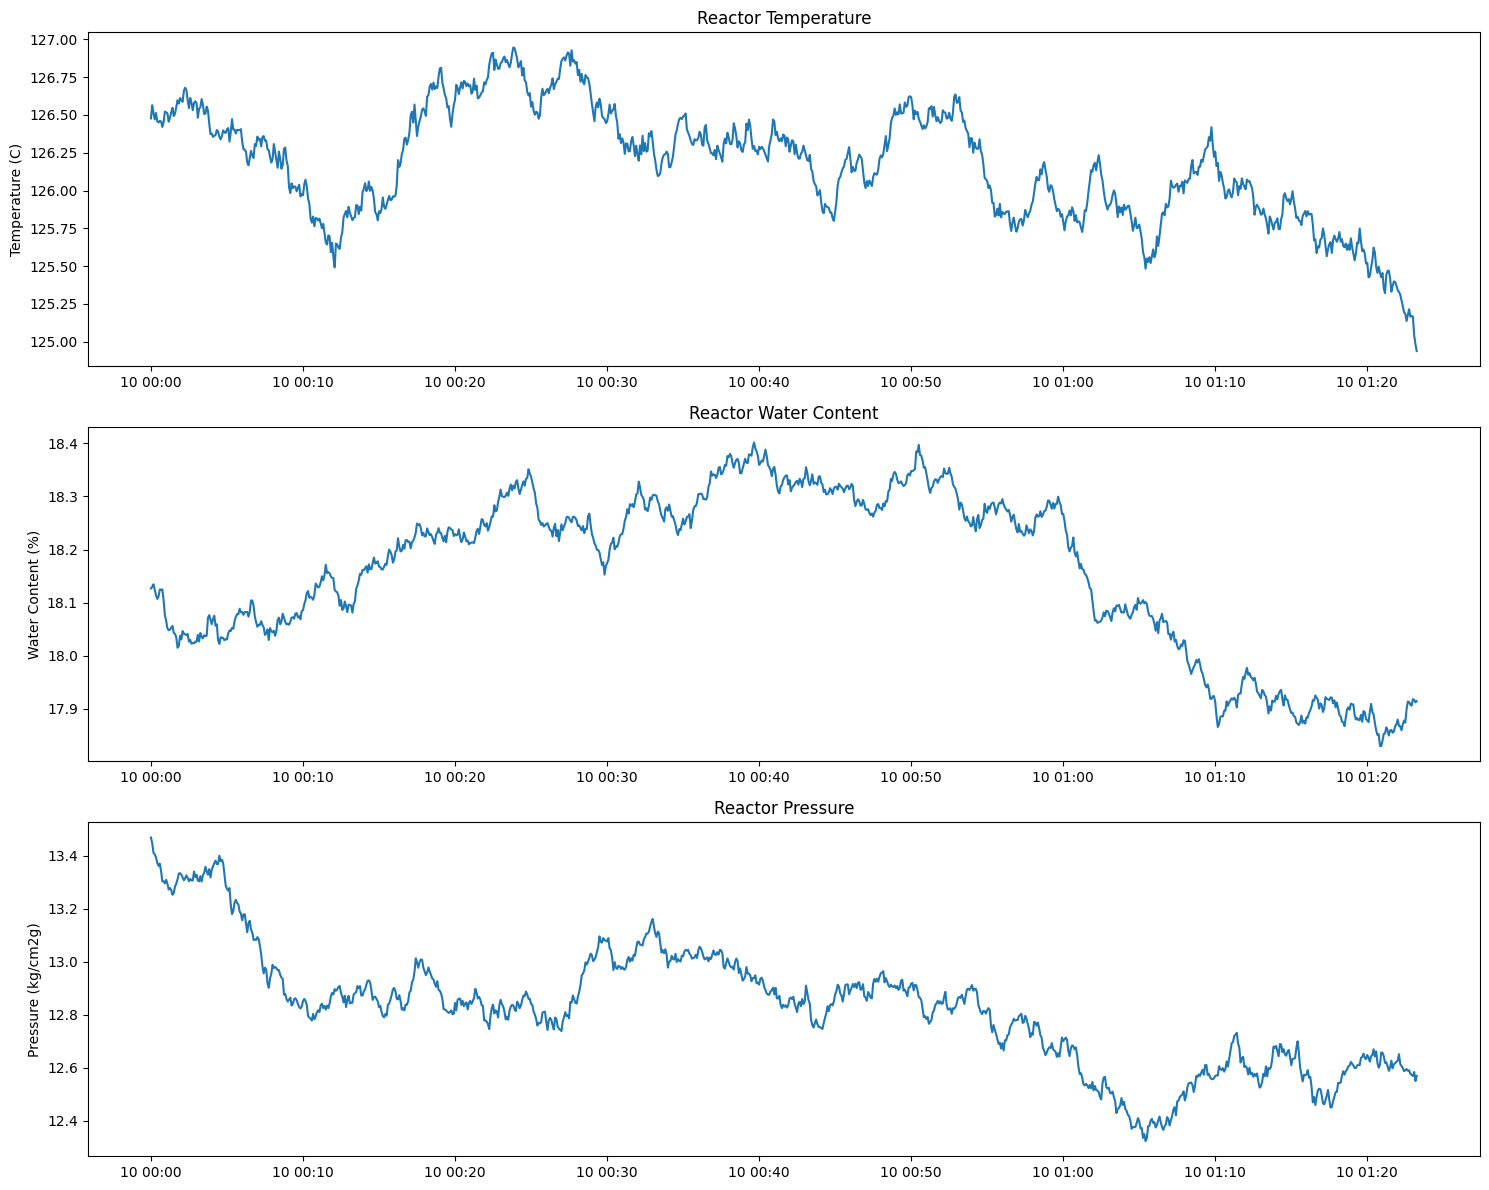

In [ ]:
#Plotting the Process Historian Data
fig, axs = plt.subplots(3, 1, figsize=(15, 12))
axs[0].plot(rw_df["Reactor_Temperature (C)"])
axs[0].set_title("Reactor Temperature")
axs[0].set_ylabel("Temperature (C)")
axs[1].plot(rw_df["Reactor_Water_Content (%)"])
axs[1].set_title("Reactor Water Content")
axs[1].set_ylabel("Water Content (%)")
axs[2].plot(rw_df["Reactor Pressure (kg/cm2g)"])
axs[2].set_title("Reactor Pressure")
axs[2].set_ylabel("Pressure (kg/cm2g)")
plt.tight_layout()
plt.show()

In [ ]:
#Reading Safety HAZOP data from excel file
#Safety data helps with more sophisticated way to deal with missing values in a control system
import requests
from io import BytesIO
from openpyxl import load_workbook
import pandas as pd

# URL of the Excel file
safety_url = "https://raw.githubusercontent.com/ardin-hsr/CHE1149-Assignment-4/main/petrochemical_plant_HAZOP.xlsx"

# Download the file
safety_response = requests.get(safety_url)

# Load workbook from bytes
safety_workbook = load_workbook(filename=BytesIO(safety_response.content))

# Select the first sheet
sheet = safety_workbook.active

# Extract data
data = []
for row in sheet.iter_rows(values_only=True):
    data.append(row)

# Convert to DataFrame
safety_df = pd.DataFrame(data[1:], columns=data[0])
pd.set_option("display.max_colwidth", None)
safety_df[safety_df['Equipment']=='Reactor']


#Based on the HAZOP sheet, if we were to use data such as reactor_temperature, reactor_pressure, and reactor_water in a control system and one of those data has a missing value, it would be
#safer to bring the ractor to a state of low catalyst concentration rather than high catalyst concentration. Thus, we would deal with missing data in the control system by for example setting
#catalyst flow set point to 0 kg/h.



,Equipment,Hazard,Description,Risk Ranking
4,Reactor,High Temperature,Oversupply of catalyst resulting in over-aggressive exothermic reaction leading to reactor high temperature possibly causing reactor leak,Very High
5,Reactor,Low Catalyst Flow,Low catalyst flow to reactor possibly resulting in lower conversion rate,Low


In [ ]:
#Textile Plant_ Recycled water parameters data_Nida
#(Fetching USGS Water Parameters Data)

import requests
import pandas as pd

#site
site = "09380000"


# The keys are USGS parameter codes, values are the desired column names.
param_code = {
    "00010": "Temperature (°C)",
    "00060": "Level (l)",
    "00400": "pH"
}

# Extract the list of parameter codes for the USGS API query from the mapping
parameters = list(param_code.keys())

# Date range
start = "2024-01-01"
end = "2024-12-31"

def get_usgs_data(site, params_map):
    """Fetch multiple parameters for a site from USGS, using a parameter code map"""
    param_str = ",".join(params_map.keys())
    url = (
        "https://waterservices.usgs.gov/nwis/dv/"
        f"?format=json&sites={site}&parameterCd={param_str}"
        f"&startDT={start}&endDT={end}&siteStatus=all"
    ) #API requires request to be in this format

    r = requests.get(url)
    r.raise_for_status()
    data = r.json()

    collected_series_dfs = {} # Use a dictionary to store one DataFrame per param_code
    try:
        for ts in data["value"]["timeSeries"]:
            param_code = ts["variable"]["variableCode"][0]['value']

            # Only process if we want this parameter and haven't already collected it
            if param_code in params_map and param_code not in collected_series_dfs:
                param_name = params_map[param_code]

                # Extract data values
                series_data = ts["values"][0]["value"]
                df_param = pd.DataFrame(series_data)
                df_param["dateTime"] = pd.to_datetime(df_param["dateTime"])
                df_param["value"] = pd.to_numeric(df_param["value"], errors="coerce")

                # Rename the 'value' column to the desired Parameter name
                df_param = df_param[["dateTime", "value"]].rename(columns={"value": param_name})
                collected_series_dfs[param_code] = df_param.set_index("dateTime")
    except (KeyError, IndexError):
        pass

    if collected_series_dfs:
        ordered_dfs = []
        # Use the order from params_map keys for consistent output order
        for code in params_map.keys():
            if code in collected_series_dfs:
                ordered_dfs.append(collected_series_dfs[code])

        if ordered_dfs:
            combined = pd.concat(ordered_dfs, axis=1)
            return combined
        else:
            return pd.DataFrame() # In case none of the desired codes were found
    else:
        return pd.DataFrame()

# Get data
df = get_usgs_data(site, param_code)

if df.empty:
    print("No data available for selected parameters.")
else:
    df.index.name = 'date'
    print("\nRecycled water parameters:")
    print(df.head())


Recycled water parameters:
            Temperature (°C)  Level (l)   pH
date                                        
2024-01-01              11.1      11300  8.3
2024-01-02              11.1      11900  8.3
2024-01-03              11.1      11900  8.3
2024-01-04              11.0      12000  8.3
2024-01-05              10.8      12000  8.3


In [ ]:
print("Missing values in Recycled_water_data:")
display(df.isnull().sum())

Missing values in Recycled_water_data:


,0
Temperature (°C),12
Level (l),0
pH,11


In [ ]:
df = df.dropna()

In [ ]:
print("Missing values in Recycled_water_data:")
display(df.isnull().sum())

Missing values in Recycled_water_data:


,0
Temperature (°C),0
Level (l),0
pH,0


In [ ]:
#Dyeing Process dataset
import pandas as pd
import requests
from io import StringIO

# Example: load CSV (replace url or file path accordingly)
url = 'https://raw.githubusercontent.com/NidaSaleem1/ARN/refs/heads/main/Textile_data.csv'
response = requests.get(url)          # API-style HTTP GET request
csv_data = response.text              # raw CSV text returned by the server

textile_data = pd.read_csv(StringIO(csv_data))  # convert CSV text → DataFrame

line1_columns = [col for col in textile_data.columns if 'date' in col or 'dyeing_line1' in col]
dyeing_line1_data = textile_data[line1_columns]

display(dyeing_line1_data.head())


,date,textile_site1_area1_dyeing_line1_temperature,textile_site1_area1_dyeing_line1_pressure,textile_site1_area1_dyeing_line1_pH,textile_site1_area1_dyeing_line1_water_level,textile_site1_area1_dyeing_line1_liquor_ratio
0,2024-11-06 00:00:00,58.62,0.60,5.28,86.45,6
1,2024-11-07 00:00:00,38.05,0.65,5.00,78.30,6
2,2024-11-08 00:00:00,76.23,0.77,5.00,66.89,6
3,2024-11-09 00:00:00,56.41,0.80,5.00,81.50,7
4,2024-11-10 00:00:00,52.63,0.60,5.11,69.28,6


In [ ]:
print("Missing values in dyeing_line1_data:")
display(dyeing_line1_data.isnull().sum())

Missing values in dyeing_line1_data:


,0
date,0
textile_site1_area1_dyeing_line1_temperature,0
textile_site1_area1_dyeing_line1_pressure,0
textile_site1_area1_dyeing_line1_pH,0
textile_site1_area1_dyeing_line1_water_level,0
textile_site1_area1_dyeing_line1_liquor_ratio,0


Dyeing data is federated because PolyTex Enterprise has multiple dyeing plants/units, each plants keep its own database (not merged into one main database)
Data is later accessed through a shared reporting interface
Dyeing data is collected and controlled via sensors,transmitters, and process control systems, so it belongs to level 1(Sensing and Process Control.) on S95 model of PolyTex

In [ ]:
#Desalter_unit1 - John

import requests
import pandas as pd

#Raw data

BASE = "https://wanita-veracious-undeleteriously.ngrok-free.dev"

# 1) Test health
print("Health:", requests.get(f"{BASE}/health").json())

# 2) Get hourly data
r = requests.get(f"{BASE}/data")
r.raise_for_status()
data_hourly = pd.DataFrame(r.json())
print("Hourly shape:", data_hourly.shape)
data_hourly.head()

# 3) Get minute data
r2 = requests.get(f"{BASE}/data", params={"freq": "minute"})
r2.raise_for_status()
data_minute = pd.DataFrame(r2.json())
print("Minute shape:", data_minute.shape)
data_minute.head()

# 4) Get summary
summary = requests.get(f"{BASE}/summary").json()
#summary
summary_df = pd.DataFrame(summary)
print(summary_df.head(10))

Health: {'status': 'ok'}
Hourly shape: (2000, 10)
Minute shape: (119941, 10)
             timestamp  feed_flow_bblh  feed_temp_C  salt_in_ppm  \
0  2025-11-01T00:00:00    45496.714153   118.649643   237.047596   
1  2025-11-01T01:00:00    44861.735699   119.710963   249.531948   
2  2025-11-01T02:00:00    45647.688538   118.415160   250.270253   
3  2025-11-01T03:00:00    46523.029856   119.384077   257.089455   
4  2025-11-01T04:00:00    44765.846625   116.212771   229.497125   
5  2025-11-01T05:00:00    44765.863043   120.426587   258.888509   
6  2025-11-01T06:00:00    46579.212816   120.002411   209.434126   
7  2025-11-01T07:00:00    45767.434729   118.365823   240.551732   
8  2025-11-01T08:00:00    44530.525614   121.318491   242.675892   
9  2025-11-01T09:00:00    45542.560044   121.875140   259.499902   

   wash_water_bblh  water_temp_C  voltage_kV  pressure_psi  salt_out_ppm  \
0      1332.887796     24.966975   17.660753     55.874070     10.635516   
1      1405.360375    

In [ ]:
#Dataframe
data_minute.head()

,timestamp,feed_flow_bblh,feed_temp_C,salt_in_ppm,wash_water_bblh,water_temp_C,voltage_kV,pressure_psi,salt_out_ppm,desalted_temp_C
0,2025-11-01T00:00:00,45496.714153,118.649643,237.047596,1332.887796,24.966975,17.660753,55.874070,10.635516,116.885851
1,2025-11-01T00:01:00,45486.131179,118.667332,237.255668,1334.095673,24.959131,17.663861,55.619587,10.639741,116.907740
2,2025-11-01T00:02:00,45475.548205,118.685021,237.463741,1335.303549,24.951287,17.666969,55.365104,10.643966,116.929629
3,2025-11-01T00:03:00,45464.965230,118.702709,237.671814,1336.511425,24.943443,17.670078,55.110622,10.648190,116.951517
4,2025-11-01T00:04:00,45454.382256,118.720398,237.879886,1337.719302,24.935600,17.673186,54.856139,10.652415,116.973406


In [ ]:
#Data understanding
data_minute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119941 entries, 0 to 119940
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   timestamp        119941 non-null  object 
 1   feed_flow_bblh   119941 non-null  float64
 2   feed_temp_C      119941 non-null  float64
 3   salt_in_ppm      119941 non-null  float64
 4   wash_water_bblh  119941 non-null  float64
 5   water_temp_C     119941 non-null  float64
 6   voltage_kV       119941 non-null  float64
 7   pressure_psi     119941 non-null  float64
 8   salt_out_ppm     119941 non-null  float64
 9   desalted_temp_C  119941 non-null  float64
dtypes: float64(9), object(1)
memory usage: 9.2+ MB


In [ ]:
#Data Format Change
data_minute['timestamp'] = pd.to_datetime(data_minute['timestamp'])

In [ ]:
# Assigning zero to negative flows

#feed_flow_bblh
condition_feed = data_minute['feed_flow_bblh'] < 0
data_minute.loc[condition_feed, 'feed_flow_bblh'] = 0

#wash_water_bbl
condition_wash = data_minute['wash_water_bblh'] < 0
data_minute.loc[condition_wash, 'wash_water_bblh'] = 0

In [ ]:
#Data transformation: Temperature Differential (ΔT Mix)
'''
This feature captures the thermal difference between the two main inputs, which is critical for good mixing and emulsion breaking.
'''
data_minute['delta_t_mix'] = data_minute['feed_temp_C'] - data_minute['water_temp_C']

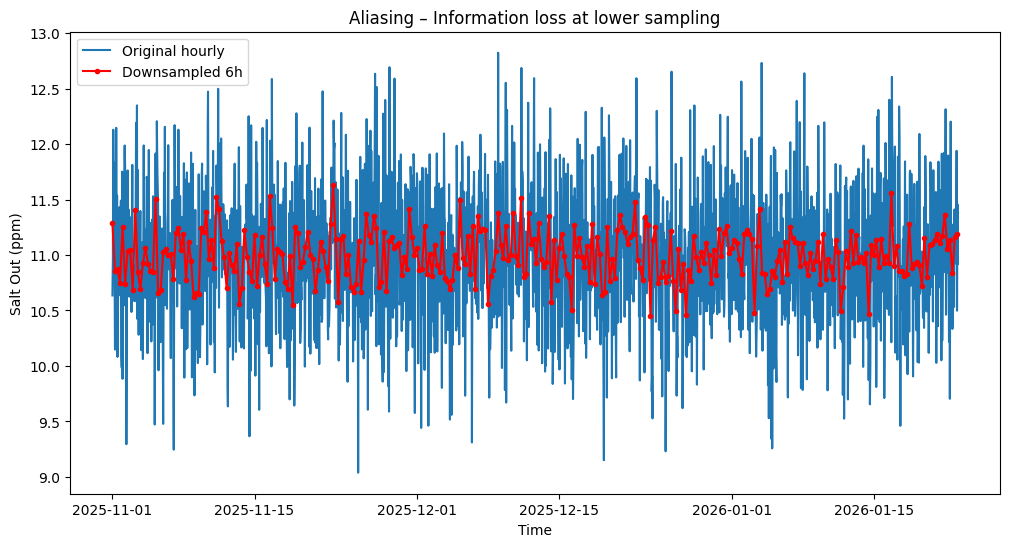

In [ ]:
#Compression/Aliasing
import matplotlib.pyplot as plt

data_minute_zip = data_minute.set_index('timestamp').resample('6h').mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(data_minute['timestamp']), data_minute['salt_out_ppm'], label='Original hourly')
plt.plot(pd.to_datetime(data_minute_zip['timestamp']), data_minute_zip['salt_out_ppm'], 'r.-', label='Downsampled 6h')
plt.title("Aliasing – Information loss at lower sampling")
plt.xlabel("Time")
plt.ylabel("Salt Out (ppm)")
plt.legend(); plt.show()

In [ ]:
import requests
import pandas as pd

# Define a simple Plant class if it's not defined elsewhere
# This is a placeholder; a more complete Plant class might be defined in a separate cell or file.
class Plant:
    def __init__(self, id=None, name=None, city=None, type=None):
        self.id = id
        self.name = name
        self.city = city
        self.type = type
        self.renewable_energy_data = None # Placeholder for data storage

# Assume 'supabase' client is available if needed, otherwise this will cause an error.
supabase = None # Placeholder; replace with actual Supabase client initialization if applicable

def generate_renewable_energy_data(self):
    """
    Fetch renewable energy forecast data from Electricity Maps API based on plant location.
    Returns forecast data including renewable percentage, carbon intensity, and electricity mix.
    """
    # Get coordinates for the plant's city
    city_coords = {
        "Toronto": (43.6532, -79.3832),
        "Houston": (29.7604, -95.3698),
        "Vancouver": (49.2827, -123.1207)
    }

    # Map cities to Electricity Maps zones
    # You can find more wherezones at: https://portal.electricitymaps.com/developer-hub/api/getting-started#geographical-coverage
    city_zones = {
        "Toronto": "CA-ON",  # Ontario, Canada
        "Houston": "US-TEX-ERCO",  # Texas ERCOT
        "Vancouver": "CA-BC"  # British Columbia, Canada
    }

    # Get zone for this plant's city
    if self.city in city_zones:
        zone = city_zones[self.city]
        if self.city in city_coords:
            latitude, longitude = city_coords[self.city]
        else:
            latitude, longitude = 43.6532, -79.3832
    else:
        # Default to Toronto/Ontario if city not found
        zone = "CA-ON"
        latitude, longitude = 43.6532, -79.3832
        print(f"Warning: City '{self.city}' not in known zones, using CA-ON")

    # Electricity Maps API endpoint for renewable energy forecast
    # Documentation: https://portal.electricitymaps.com/developer-hub/api/reference/renewable-energy
    url = "https://api.electricitymaps.com/v3/carbon-intensity/past?datetime=2025-11-09+01%3A05"

    headers = {
        "auth-token": "r1aC7eCYktQufOGUxb3e"
    }

    params = {
        "zone": zone,
        "temporalGranularity": "hourly"  # Options: '5_minutes', '15_minutes', 'hourly'
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        data = response.json()

        # Extract forecast data
        if data and len(data) > 0:
            # Convert to DataFrame
            forecast_list = []
            for entry in data:
                forecast_list.append({
                    "timestamp": pd.to_datetime(entry.get("datetime")),
                    "renewable_percentage": entry.get("renewablePercentage", 0),
                    "carbon_intensity": entry.get("carbonIntensity", 0),
                    "is_estimated": entry.get("isEstimated", False),
                    "estimation_method": entry.get("estimationMethod", "")
                })

            renewable_df = pd.DataFrame(forecast_list)
            renewable_df.set_index('timestamp', inplace=True)

            # Add metadata
            renewable_df['zone'] = zone
            renewable_df['latitude'] = latitude
            renewable_df['longitude'] = longitude

            self.renewable_energy_data = renewable_df

            # Store in Supabase
            if supabase is not None:
                self.store_renewable_energy_to_supabase(renewable_df)

            print(f"Renewable energy forecast data fetched successfully for {self.name} in {self.city} (Zone: {zone})")
            print(f"Forecast contains {len(renewable_df)} hours of data")
            return renewable_df
        else:
            print(f"Warning: No forecast data found in API response")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error fetching renewable energy data: {e}")
        if hasattr(e, 'response') and e.response is not None:
            print(f"Response status: {e.response.status_code}")
            print(f"Response body: {e.response.text}")
        return None
    except KeyError as e:
        print(f"Error parsing renewable energy data: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

# Attach method to Plant base class (works for all plant types)
Plant.generate_renewable_energy_data = generate_renewable_energy_data
df.head()

,Temperature (°C),Level (l),pH
date,,,
2024-01-01,11.1,11300,8.3
2024-01-02,11.1,11900,8.3
2024-01-03,11.1,11900,8.3
2024-01-04,11.0,12000,8.3
2024-01-05,10.8,12000,8.3


In [ ]:
#Storing Renewable Energy Data to Supabase - Miguel
def store_renewable_energy_to_supabase(self, renewable_df):
    """
    Store renewable energy forecast data to Supabase database.
    This allows for historical tracking and energy optimization decisions.
    """
    if supabase is None:
        print("Supabase client not initialized. Skipping database storage.")
        return

    try:
        # Convert DataFrame to dictionary for Supabase
        df_copy = renewable_df.reset_index()

        # Prepare data for insertion
        for _, row in df_copy.iterrows():
            record = {
                "plant_id": self.id,
                "plant_name": self.name,
                "plant_city": self.city,
                "plant_type": self.type,
                "timestamp": row['timestamp'].isoformat() if pd.notna(row['timestamp']) else None,
                "renewable_percentage": float(row['renewable_percentage']) if pd.notna(row['renewable_percentage']) else None,
                "carbon_intensity": float(row['carbon_intensity']) if pd.notna(row['carbon_intensity']) else None,
                "zone": str(row['zone']) if pd.notna(row['zone']) else None,
                "latitude": float(row['latitude']) if pd.notna(row['latitude']) else None,
                "longitude": float(row['longitude']) if pd.notna(row['longitude']) else None,
                "is_estimated": bool(row['is_estimated']) if pd.notna(row['is_estimated']) else None,
                "estimation_method": str(row['estimation_method']) if pd.notna(row['estimation_method']) else None
            }

            # Insert into Supabase (assuming table name is 'renewable_energy')
            response = supabase.table("renewable_energy").insert(record).execute()

        print(f"Renewable energy data stored in Supabase for {self.name} ({len(df_copy)} records)")

    except Exception as e:
        print(f"Error storing data to Supabase: {e}")

# Attach method to Plant base class
Plant.store_renewable_energy_to_supabase = store_renewable_energy_to_supabase
df.head()

,Temperature (°C),Level (l),pH
date,,,
2024-01-01,11.1,11300,8.3
2024-01-02,11.1,11900,8.3
2024-01-03,11.1,11900,8.3
2024-01-04,11.0,12000,8.3
2024-01-05,10.8,12000,8.3
